In [1]:
using AR1
using Color
using Distributions
using Gadfly
using Kepler
using Periodogram
using RVPosterior

 in depwarn at ./deprecated.jl:63
 in require at deprecated.jl:648
 in include at ./boot.jl:254
 in include_from_node1 at ./loading.jl:263
 in require at ./loading.jl:202
 in include at ./boot.jl:254
 in include_from_node1 at ./loading.jl:263
 in require at ./loading.jl:202
 in include_string at loading.jl:225
 in execute_request_0x535c5df2 at /Users/farr/.julia/v0.4/IJulia/src/execute_request.jl:157
 in eventloop at /Users/farr/.julia/v0.4/IJulia/src/IJulia.jl:123
 in anonymous at task.jl:447
while loading /Users/farr/.julia/v0.4/Compose/src/Compose.jl, in expression starting on line 131


In [16]:
data = readdlm("../../RV_challenge_dataset/PlSystem1_harps.rdb", skipstart=1)
ts = data[:,1]
vs = data[:,2]
dvs = data[:,3]
preds = data[:,[4,6,10]]
nothing

Are the predictors correlated with vs?

In [17]:
cor(cat(2, vs, preds))

4x4 Array{Float64,2}:
 1.0       0.818145  0.264681  0.847666
 0.818145  1.0       0.660931  0.962424
 0.264681  0.660931  1.0       0.570499
 0.847666  0.962424  0.570499  1.0     

In [18]:
post = RVPosterior.Posterior(ts, vs, dvs, preds, 0)
p0 = Float64[mean(vs), log(std(vs)), log(0.1*(ts[end]-ts[1])), 0.0, randn(), randn(), randn()]
ps = zeros(7, 128)
for i in 1:128
    ps[:,i] = p0 + 1e-5*randn(7)
end
lnps = Float64[RVPosterior.lnprob(post, ps[:,i]) for i in 1:128]
nothing

In [19]:
ps, lnps = Ensemble.EnsembleSampler.run_mcmc(ps, lnps, x -> RVPosterior.lnprob(post, x), 1000, thin=10)
nothing

In [20]:
@time ps, lnps = Ensemble.EnsembleSampler.run_mcmc(ps[:,:,end], lnps[:,end], x->RVPosterior.lnprob(post, x), 1000, thin=10)
nothing

  9.405701 seconds (71.05 M allocations: 3.280 GB, 10.14% gc time)


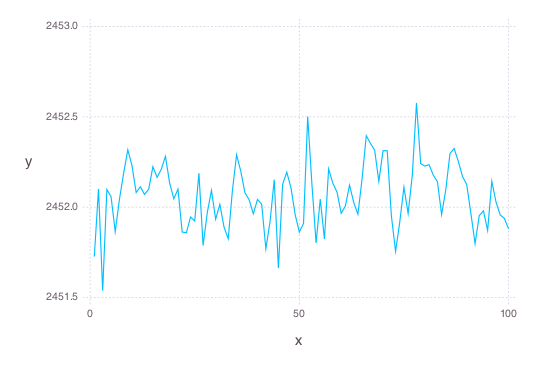

In [21]:
plot(x=1:100, y=mean(lnps,1), Geom.line)

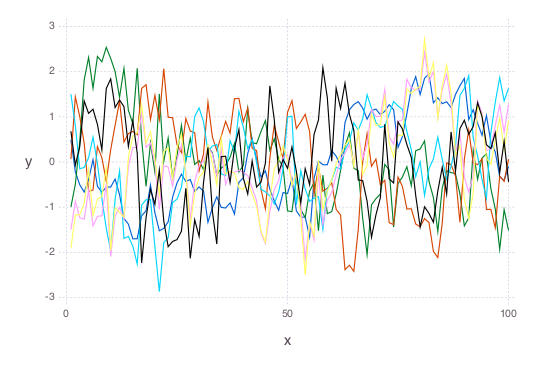

In [22]:
Ensemble.Plots.chain_plot(ps)

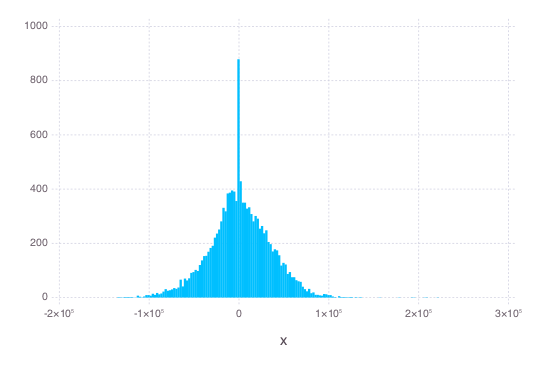

In [23]:
plot(x=ps[1,:,:]-mean(vs), Geom.histogram)

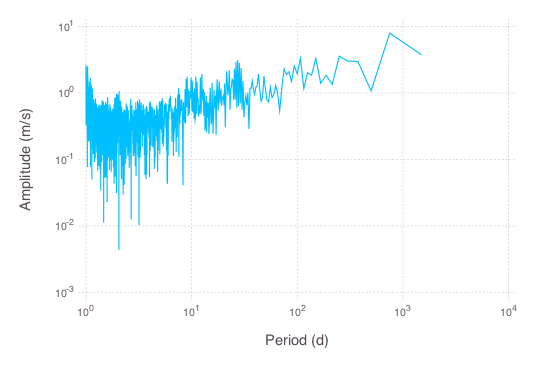

In [50]:
dt = minimum(diff(ts))
T = ts[end]-ts[1]
fny = 1.0/(2*dt)
df = 1.0/T
fmax = 1.0
fs = collect(df:df:fmax)
amps = Periodogram.periodogram(ts, 1000*vs, fs)
plot(x=1.0./fs, y=amps, Geom.line, Scale.x_log10, Scale.y_log10, Guide.XLabel("Period (d)"), Guide.YLabel("Amplitude (m/s)"))

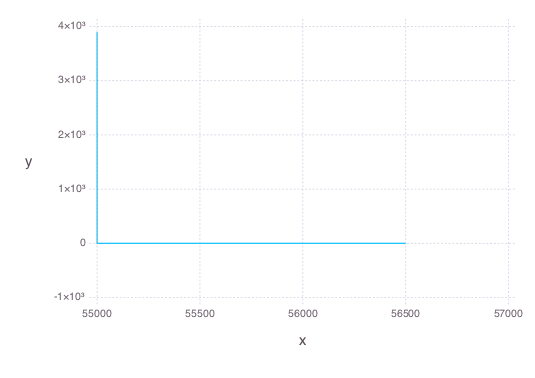

In [233]:
rs = zeros(size(ts,1))
for i in 1:128
    p = ps[:,i,end]
    rs += RVPosterior.uncorr_resid(RVPosterior.toparams(post, p), ts, vs, dvs, preds)[1]
end
rs = rs ./ 128.0
plot(x=ts, y=rs, Geom.line)
#amps = Periodogram.periodogram(ts, rs, fs)
#plot(x=1.0./fs, y=amps, Geom.line, Scale.x_log10, Scale.y_log10)

In [5]:
reload("AR1")

In [6]:
function ar1post(p, ts, xs, dxs)    
    if p[2] < 0
        return -Inf
    end
    if p[3] < 0
        return -Inf
    end
    if p[4] < 0
        return -Inf
    end
    
    r, s = AR1.residuals(AR1.AR1Model(p...), ts, xs, dxs)
    
    lp = 0.0
    for i in eachindex(r)
        lp += -log(s[i]) -0.5*r[i]*r[i]/(s[i]*s[i])
    end
    lp
end

ar1post (generic function with 1 method)

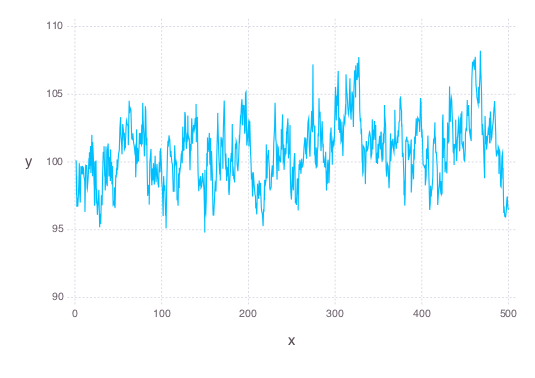

In [7]:
p0 = [100.0, 2.3, 5.3, 1.1]
dxs = rand(1000)
ts = cumsum(rand(1000))
xs = AR1.simulate(AR1.AR1Model(p0...), ts, dxs)
plot(x=ts, y=xs, Geom.line)

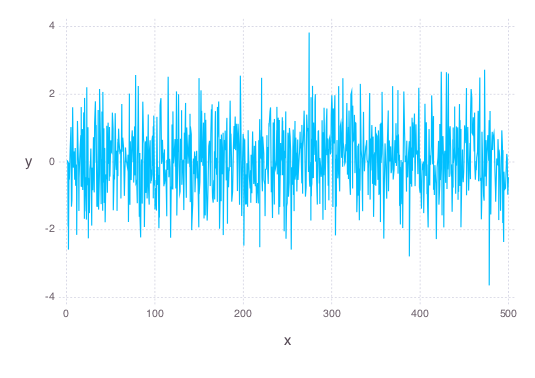

In [8]:
r,s = AR1.residuals(AR1.AR1Model(p0...), ts, xs, dxs)
plot(x=ts, y=r./s, Geom.line)

In [9]:
ps = zeros(4, 128)
for i in 1:128
    ps[:,i] = p0 + 1e-3*randn(4)
end
lnps = Float64[ar1post(ps[:,i],ts,xs,dxs) for i in 1:128]
nothing

In [10]:
ps,lnps = Ensemble.EnsembleSampler.run_mcmc(ps, lnps, x -> ar1post(x, ts, xs, dxs), 1000, thin=10)
nothing

In [11]:
ps,lnps = Ensemble.EnsembleSampler.run_mcmc(ps[:,:,end], lnps[:,end], x -> ar1post(x, ts, xs, dxs), 1000, thin=10)
nothing

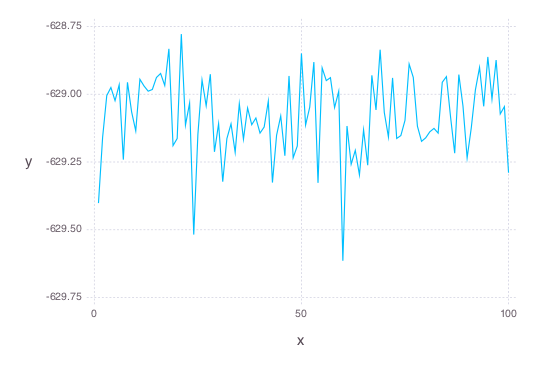

In [12]:
plot(x=1:100, y=mean(lnps, 1), Geom.line)

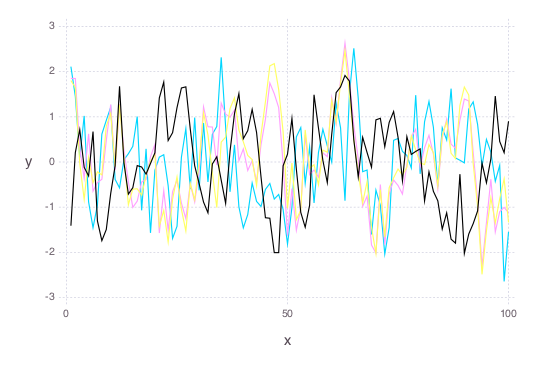

In [13]:
Ensemble.Plots.chain_plot(ps)

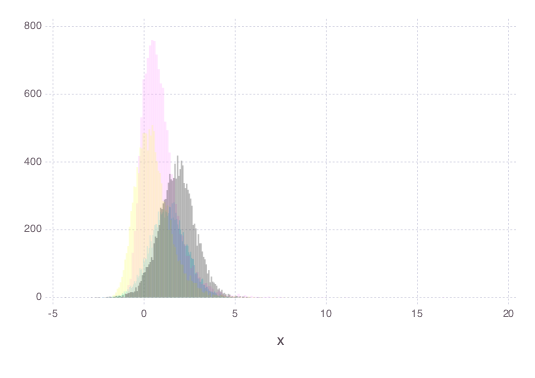

In [14]:
cs = distinguishable_colors(size(ps,1))
layers = [layer(x=(ps[i,:,:]-p0[i])/std(ps[i,:,:]), Geom.histogram, Theme(default_color=color(AlphaColorValue(cs[i], 0.25)))) for i in 1:4]
plot(layers...)